# Interactive Occlusion Heatmap slider for all models

For a given patient id the occlusion heatmap is calculated for all models and displayed in a slider.
The size of the occlusion can be adjusted manually.

### Imports

In [1]:
%matplotlib inline
import os
import h5py
import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.2.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)

/tf


In [3]:
import functions_model_definition as md
import functions_read_data as rdat
import functions_occlusion as oc
import functions_gradcam as gc
import functions_plot_heatmap as phm
import functions_slider as sl

### Load Data and Set Parameters

In [4]:
# Define the path + output path:
DATA_DIR = DIR + "data/"
#version = "andrea"
#version = "andrea" # one of:
version = "10Fold_sigmoid_V0" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False

# Define Model Version
model_version = 1

# define paths
WEIGHT_DIR, DATA_OUTPUT_DIR, PIC_OUTPUT_DIR, pic_save_name = rdat.dir_setup(
    DIR, version, model_version)

In [5]:
## load images and ids
(X_in, pat, id_tab, all_results, num_models) = rdat.version_setup(
    DATA_DIR = DATA_DIR, version = version, model_version = model_version)
## load patient data
PAT_CSV_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/baseline_data_zurich_prepared0.csv" 
pat_dat = pd.read_csv(PAT_CSV_DIR, sep=";")
pat_dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia,iaty,ivty
0,101,1,"85,6",0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN
1,102,1,"66,7",1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN,NaN
2,103,0,"29,2",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,104,0,83,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,NaN,NaN
4,105,6,"89,2",0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,540,2,80,0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0
514,541,0,19,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1
515,542,1,68,1,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0
516,543,4,74,0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0


## Model

In [6]:
# define model
(input_dim, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)

model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [7]:
# Define Model Name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR)                                                 


In [8]:
generate_model_name

<function functions_model_definition.set_generate_model_name.<locals>.generate_model_name(which_split, model_nr)>

# Occlusion without slider

In [9]:
all_results.reset_index().p_id[3]

5

In [10]:
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
205,1,1,1.0,0,val,train,train,train,train,test,...,0.006181,0.013081,0.010683,0.014991,0.012591,0.225491,0,0.011203,0.023237,True
206,2,2,1.0,0,val,train,train,train,train,test,...,0.024134,0.049767,0.028247,0.041919,0.037599,0.225491,0,0.023930,0.066490,True
367,3,3,0.0,0,train,train,train,train,val,train,...,0.131908,0.243230,0.315786,0.214386,0.204826,0.225491,0,0.080713,0.259467,True
41,4,5,0.0,0,train,test,train,train,train,train,...,0.716669,0.567527,0.606706,0.632576,0.635252,0.225491,1,0.073403,0.234623,False
246,5,6,3.0,1,train,val,train,train,train,train,...,0.245842,0.348741,0.214166,0.255132,0.251216,0.225491,1,0.062966,0.199155,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,403,555,0.0,0,train,test,train,train,train,train,...,0.149244,0.191791,0.250303,0.174730,0.170676,0.225491,0,0.048965,0.151572,True
122,404,556,0.0,0,train,train,test,train,train,train,...,0.005016,0.002759,0.005417,0.005433,0.004173,0.225491,0,0.004365,0.000000,True
406,405,557,1.0,0,train,train,train,train,val,train,...,0.017060,0.018309,0.032593,0.021798,0.021210,0.225491,0,0.006236,0.006357,True
366,406,559,1.0,0,train,train,train,val,train,train,...,0.382259,0.497347,0.451662,0.383475,0.379759,0.225491,1,0.094122,0.305038,False


In [12]:
(res_table, res_images, res_model_names) = gc.get_img_and_models(
        [162], results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)

In [13]:
res_table

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,261,115,162,0.0,0,train,val,train,train,train,...,0.378053,0.12393,0.146108,0.239116,0.224543,0.225491,0,0.109735,0.358099,True


Two different occlusions are recommended.  
However, the occlusion can also be defined by the user. The third row of the following output must be all 0 and the fourth row must be True and the occlusion will work.

In [14]:
### occlusion
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6
print("number of occlusions: ", int(np.prod(((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)))
print("number of occlusions per axis: ", ((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)
print((np.asarray(res_images.shape[1:4]) - occ_size) % occ_stride) # all must be zero
print(all(np.array(occ_size) > occ_stride)) # must be true
print(np.array(res_images.shape[1:4]) / occ_size) # if all same, then same ratio of occ_size to image size

number of occlusions:  1600
number of occlusions per axis:  [20. 20.  4.]
[0 0 0]
True
[9.14285714 9.14285714 2.8       ]


In [16]:
import time
from importlib import reload
reload(oc)

start = time.time()
(heatmap, resized_img, max_hm_slice, hm_mean_std) =  oc.volume_occlusion(
    volume = res_images, 
    res_tab = res_table, 
    occlusion_size = np.array(occ_size), 
    normalize = True,
    both_directions = False,
    invert_hm = "never",
    cnn = model_3d,
    model_names = res_model_names[0][:], # select model
    occlusion_stride = occ_stride)

end = time.time()
print(end - start)

32.23646402359009


In [18]:
hm_mean_std

0.0574221

In [ ]:
#88,72,12

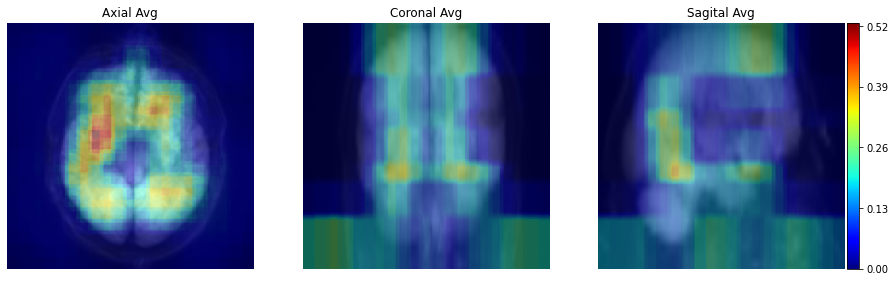

In [20]:
phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "avg",
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

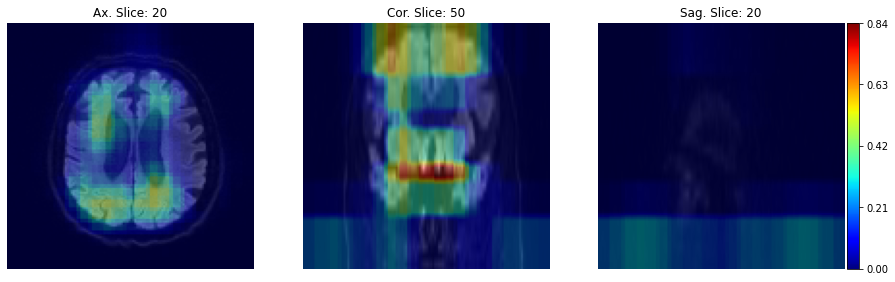

In [21]:
phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (50,20,20),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

# Occlusion Slider

In [30]:
import numpy as np
import ipywidgets as widgets

from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox, Layout, AppLayout
from IPython.display import display
from termcolor import colored

import functions_gradcam as gc
import functions_occlusion as oc
import functions_plot_heatmap as phm

# generates a occlusion heatmap plot/slider for a given patient id
# first row shows the average heatmap over each direction
# second row shows a slider to select the heatmap slice (default is the maximum heatmap slice)
# third row shows the original image with the same slider as in the second row
# additionally some meta information is printed
# 
# all heatmaps can be provided in the same order as X_in or will be generated if None
# if None then the model arguments are required 
# if the heatmap is provided then pred_hm_only does only change the colorbar

def occlusion_interactive_plot(p_id, occ_size, occ_stride,
                               cnn, all_results, pat, X_in,
                               generate_model_name, num_models,
                               pat_dat,
                               pred_hm_only=True,
                               heatmaps = None):
    # p_id: patient id
    # occ_size: size of the occlusion window
    # occ_stride: stride of the occlusion window (if None then occ_stride = occ_size)
    # cnn: the cnn model (weights must not be loaded)
    # all_results: the result table 
    # pat: the patient ids of the images (same order as X_in)
    # X_in: the images (same order as pat)
    # generate_model_name: function to generate the model names
    # num_models: number of models per fold
    # pat_dat: the patient data table
    # pred_hm_only: if True then the heatmap is only plotted for the predicted class
    #               if False then the positive and negative heatmap is plotted
    # heatmaps: if None then the heatmaps are generated, otherwise the heatmaps must be provided (same order as X_in)
    
    p_ids = [p_id]
    (res_table, res_images, res_model_names) = gc.get_img_and_models(
        p_ids, results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)
    
    print("patient id: ", res_table.p_id[0])
    print("age: ", pat_dat[pat_dat["p_id"] == res_table.p_id[0]]["age"].values[0])
    print("true mrs: ", res_table.mrs[0])
    print("true class: ", res_table.unfavorable[0])
    print(colored("pred class: "+str(res_table.y_pred_class[0]), 
                'green' if res_table["pred_correct"][0] == True else 'red'))
    print("pred prob (class 1): ", res_table.y_pred_trafo_avg[0])
    print("pred prob (class 1): ", res_table.y_pred_trafo_avg[0])
    print("pred uncertainty: ", res_table.y_pred_unc[0])
    # print("heatmap unc. last layer: ", res_table.y_pred_unc[0])
      
    ## Generate heatmap
    if pred_hm_only:
        invert_hm = "pred_class"
        both_directions = False
        cmap = "jet"
        hm_positive=True
    else:
        invert_hm = "never"
        both_directions = True
        cmap = "bwr"
        hm_positive=False   
    
    if heatmaps is None:
        (heatmap, resized_img, max_hm_slice, hm_mean_std) =  oc.volume_occlusion(
            volume = res_images, 
            res_tab = res_table, 
            occlusion_size = np.array(occ_size), 
            cnn = cnn,
            invert_hm=invert_hm,
            both_directions=both_directions,
            model_names = res_model_names[0],
            occlusion_stride = occ_stride)
    else:
        heatmap = heatmaps[np.argwhere(pat == p_id).squeeze()]
        resized_img = res_images[0]
    
    slices = np.unravel_index(heatmap.argmax(), heatmap.shape)
    print("max slices:", (slices[2], slices[0], slices[1]))
    
    ## Plot Heatmap Average
    phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "avg",
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)

    ## Plot Heatmap Slider
    def slicer(axi_slider, cor_slider, sag_slider):
        phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                colorbar=True)
        phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "original",
                mode = "def",
                slices=(cor_slider,sag_slider,axi_slider),
                hm_colormap=cmap,
                hm_positive=hm_positive,
                slice_line=True)

    w=interactive(
        slicer, 
        axi_slider=widgets.IntSlider(value=slices[2],min=0,max=27,step=1), 
        cor_slider=widgets.IntSlider(value=slices[0],min=0,max=127,step=1), 
        sag_slider=widgets.IntSlider(value=slices[1],min=0,max=127,step=1))

    slider_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='9.2in')
    images_layout = Layout(display='flex', flex_flow='row', 
                        justify_content='space-between', align_items='center',
                        width='15', height='15')

    display(VBox([
        HBox([w.children[0],w.children[1], w.children[2]], layout=slider_layout),
        HBox([w.children[3]], layout=images_layout)
    ]))      
    w.update()

patient id:  148
age:  75,3
true mrs:  0.0
true class:  0
pred class: 1
pred prob (class 1):  0.26747116
pred prob (class 1):  0.26747116
pred uncertainty:  0.13186744
max slices: (16, 50, 38)


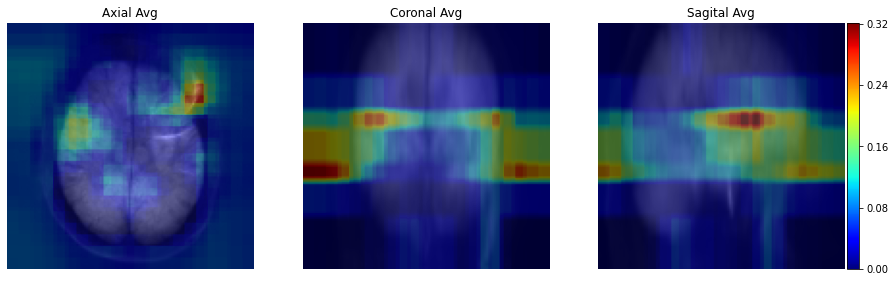

In [31]:
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6

occlusion_interactive_plot(
    148, # patient id
    occ_size = occ_size, occ_stride = occ_stride,
    cnn=model_3d, all_results=all_results, pat=pat, X_in=X_in,
    generate_model_name=generate_model_name, num_models=num_models,
    pat_dat=pat_dat,
    pred_hm_only=True) # if True, only the heatmap for the predicted class is shown, otherwise also negative heatmaps are shown